In [1]:
import kalman_filter as kalman_filter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import plotly.graph_objects as px
from sklearn.metrics import r2_score

In [2]:
# read data
timest=[0]
data_filename = '../data/book.csv'
df=pd.read_csv(data_filename)

In [3]:
#reducing data size for easy computation
df2=df[550000:600000]
df1=df2['COLLECTION_TIME'].values
deltaTime=0
sumi=0
price=[]
consttime=100000000
sum1=0

In [4]:
#%% convert time to nano seconds raw and poll price at constant rate
for k in range(1,int(len(df2))):
    head1,sep1,tail1=df1[k-1].partition('.')
    head2,sep2,tail2=df1[k].partition('.')
    firstStamp = pd.to_datetime(head1, format='%Y-%m-%dT%H:%M:%S')
    lastStamp = pd.to_datetime(head2, format='%Y-%m-%dT%H:%M:%S')
    deltaTime = deltaTime+(lastStamp - firstStamp).total_seconds()*1e9+(int(tail2)-int(tail1))
    timest.append(deltaTime)
    while sum1<deltaTime:
        
        price.append((df2['BID_PRICE_1'].values[k]*df2['BID_SIZE_1'].values[k]+df2['BID_PRICE_2'].values[k]*df2['BID_SIZE_2'].values[k]
              +df2['BID_PRICE_3'].values[k]*df2['BID_SIZE_3'].values[k]+df2['ASK_PRICE_3'].values[k]*df2['ASK_SIZE_3'].values[k]
              +df2['ASK_PRICE_2'].values[k]*df2['ASK_SIZE_2'].values[k]+df2['ASK_PRICE_1'].values[k]*df2['ASK_SIZE_1'].values[k])/
             (df2['ASK_SIZE_1'].values[k]+df2['ASK_SIZE_2'].values[k]+df2['ASK_SIZE_3'].values[k]+df2['BID_SIZE_1'].values[k]+
              df2['BID_SIZE_2'].values[k]
              +df2['BID_SIZE_3'].values[k]))
        sum1=sum1+consttime
    sumi=sumi+1
       
    

In [5]:
# init kalman filter
x = np.full((2, 1), 2)
P = np.full((2, 2), 2 ** 2)
state = kalman_filter.State(x, P)

Q = np.full((2, 2), 1 ** 2)
F = np.array([[1, 1],
              [0, 1]])
R = np.array([[0.5 ** 2]])
H = np.array([[1, 0]])

In [6]:
# data for plotting
gt = {'price': [], 'trend': []}
result = {'price': [], 'trend': []}
velocity = []
res=[]
res2=[]

counter = 0

for ik in range(0, len(price)):
    z = np.array([[price[ik]]])

    if counter == 0:
        x = np.array([[z[0][0]], [0]])
        state = kalman_filter.State(x, P)

    prior = kalman_filter.predict(state, F, Q)
    posterior = kalman_filter.update(prior, z, R, H)
    state = posterior

    gt['price'].append(z[0][0])
    result['price'].append(prior.X[0][0])
    velocity.append(prior.X[1][0])

    if counter == 0:
        gt['trend'].append(1)
        result['trend'].append(1)
        res.append(0)
        res2.append(0)
    else:
        predicted_trend = 1 if prior.X[0][0] > result['price'][counter - 1] else -1
        result['trend'].append(predicted_trend)
        gt_trend = 1 if z[0][0] > gt['price'][counter - 1] else -1
        gt['trend'].append(gt_trend)
        res1=100 if gt_trend==predicted_trend else 0
        res.append(res1)
        res2.append(res1-100)

    counter += 1
    # if counter > 20:
    #    break

correct direction predictions 3871
percentage of correct predictions 0.4603401117849923
r2 score of percentage change in price -0.6099796278879865


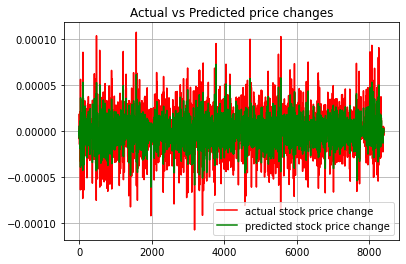

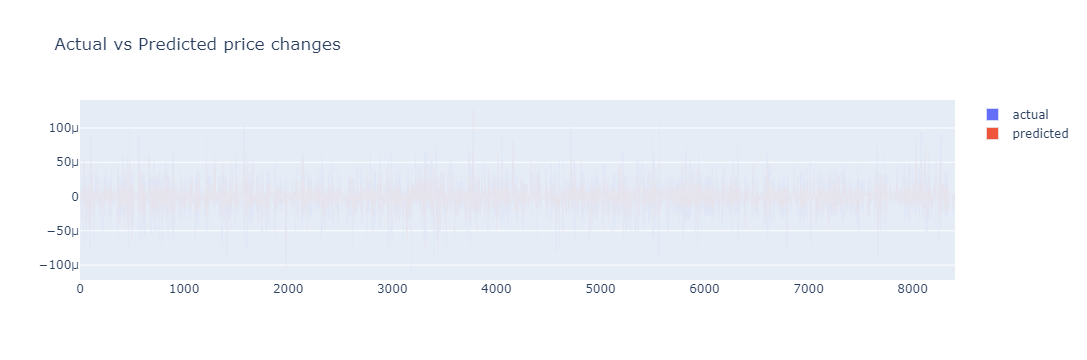

In [9]:
# KPI
# number of correct trend predictions
correct_predictions = 0
for x, y in zip(result['trend'], gt['trend']):
    if x == y:
        correct_predictions += 1
print('correct direction predictions',str(correct_predictions))

print('percentage of correct predictions',str(float(correct_predictions) / len(gt['trend'])))


actual_percent=[]
predicted_percent=[]

for k in range(1,len(gt['price'])):
    actual_percent.append((gt['price'][k]-gt['price'][k-1])/gt['price'][k])
    predicted_percent.append((result['price'][k]-gt['price'][k-1])/gt['price'][k])

print('r2 score of percentage change in price',str(r2_score(actual_percent,predicted_percent)))

plt.figure(2)
plt.plot((actual_percent),'r',label='actual')
plt.plot((predicted_percent),'g',label='predicted')
plt.title('Actual vs Predicted price changes')


plt.legend(['actual stock price change', 'predicted stock price change'])
plt.title('Actual vs Predicted price changes')
plt.grid()
plt.show()



fig = px.Figure(data=[
    px.Bar(name='actual', y=actual_percent),
    px.Bar(name='predicted', y=predicted_percent)
])

fig.update_layout(barmode='relative',title='Actual vs Predicted price changes')
fig.show()